## Sensor Selection

This is the fundamental greedy algorithm implementation. 

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

def get_labels_from_df(df, from_idx, to_idx, label_idx):
    labeled_edges = {}
    for e in df.itertuples():
        labeled_edges[(e[from_idx], e[to_idx])] = e[label_idx]
    return labeled_edges

In [2]:
from scipy.sparse import linalg

def flow_prediction(G, labelled_flows, lamb=1e-6):
    '''
        Flow prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    b = np.zeros(n_labelled_edges)
    B = nx.incidence_matrix(G, oriented=True)
    f0 = np.zeros(G.number_of_edges())

    i = 0
    j = 0
    U = []
    index = {}
    for e in G.edges():
        if e in labelled_flows:
            f0[i] = labelled_flows[e]
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    b = -B.dot(f0)
 
    A = B[np.ix_(np.arange(B.shape[0]), U)]

    res = linalg.lsmr(A, b, damp=lamb)
    x = res[0]

    pred_flows = {}
    
    for e in G.edges():
        if e in labelled_flows:
            pred_flows[e] = labelled_flows[e]
        else:
            pred_flows[e] = x[index[e]]
    
    return pred_flows

In [3]:
def mse(pred_labels, labeled_edges):
    return sum([(v - pred_labels[k]) ** 2 for k, v in labeled_edges.items()]) / len(labeled_edges)     

In [86]:
from tqdm.notebook import tqdm
from multiprocess import Pool 
import heapq

def choose_sensors(G, labeled_edges, predict, evaluate, k=None, lazy=False):
    """
    Choose `k` sensors greedily to optimize the prediction given by `predict` for ground truth `labels`
    based on loss function `evaluate` (lower loss is better). 
    
    Parameters:
        -- G: networkx graph
        -- labeled_edges: dict {edge : value}
        -- predict: function taking G, labeled_edges -> prediction
        -- evaluate: prediction, true_values -> loss
    """
    if k == None:
        k = int(G.number_of_edges() / 50)
    
    sensors = []
        
    # Find value of adding each edge not in the set
    current = evaluate(predict(G, {}), labeled_edges)

    with Pool(4) as pool:
        deltas = pool.map(lambda e: (evaluate(predict(G, {e : labeled_edges[e]}), labeled_edges) - current, e), 
                          labeled_edges)

#     deltas = []
#     current = evaluate(predict(G, {}), labeled_edges)
#     print("baseline (no sensors) mse {}".format(current))
#     for e in tqdm(labeled_edges):
#         delta = (evaluate(predict(G, {e : labeled_edges[e]}), labeled_edges) - current, e)
#         deltas.append(delta)
    heapq.heapify(deltas)
    
    # Greedily select sensors
    if lazy:
        for i in tqdm(range(k)):
            current = evaluate(predict(G, {e: labeled_edges[e] for e in sensors}), labeled_edges)
#             print("iteration {}, current {}".format(i, current))

            # Current top 
            _, s = heapq.heappop(deltas)
            delta = evaluate(predict(G, {e: labeled_edges[e] for e in sensors} | {s : labeled_edges[s]}), 
                             labeled_edges) - current

            # Next top
            delta_next, s_next = heapq.heappop(deltas)
            delta_next -= current
#             print("sensor {} delta {}".format(s, delta))
#             print("next top sensor {} delta {}".format(s_next, delta_next))
#             print("deltas: {}".format(deltas))

            # Compute change in top node
            # If the change drops it below the next best, recalculate the next best and continue
            while delta - delta_next > 1e-3:
#                 print("sensor {} delta {}".format(s, delta))
#                 print("next top sensor {} delta {}".format(s_next, delta_next))
                delta_next = evaluate(predict(G, {e: labeled_edges[e] for e in sensors} | {s_next : labeled_edges[s_next]}), 
                             labeled_edges) - current
                if delta_next < delta:
                    heapq.heappush(deltas, (delta, s))
                    delta, s = delta_next, s_next
                else:
                    heapq.heappush(deltas, (delta_next, s_next))
                    delta_next, s_next = heapq.heappop(deltas)
#             print("selecting sensor {} delta {}, next sensor {} has delta {}".format(s, delta, s_next, delta_next))
            sensors.append(s)
#             print()
    else:
        for i in tqdm(range(k)):
            current = evaluate(predict(G, {e: labeled_edges[e] for e in sensors}), labeled_edges)
            # print("iteration {}, current {}".format(i, current))
            opt, opt_cost = None, float("inf")
            for s in G.edges():
                if s not in sensors:
                    cost = evaluate(predict(G, {e : labeled_edges[e] for e in sensors} | {s : labeled_edges[s]}),
                                   labeled_edges)
                    # print("sensor {} cost {} opt {}".format(s, cost, opt_cost))
                    if cost < opt_cost:
                        opt, opt_cost = s, cost
            sensors.append(opt)
        
    return sensors

### Testing

Should choose one node from each cluster

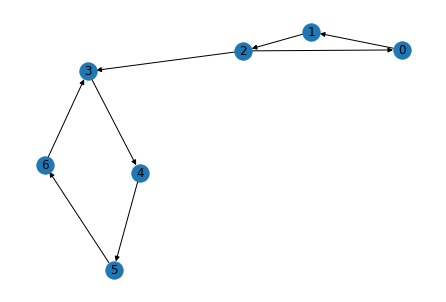

In [69]:
J = nx.DiGraph()

J.add_edge(0,1)
J.add_edge(1,2)
J.add_edge(2,0)
J.add_edge(2,3)
J.add_edge(3,4)
J.add_edge(4,5)
J.add_edge(6,3)
J.add_edge(5,6)

flows = {}

flows[(0,1)] = 10.
flows[(1,2)] = 10
flows[(2,0)] = 10.
flows[(2,3)] = 0.
flows[(3,4)] = 10.
flows[(4,5)] = 10.
flows[(6,3)] = 10
#flows[(6,4)] = 10.
flows[(5,6)] = 10.

np.random.seed(20)
nx.draw(J, with_labels=True)

In [70]:
opt = choose_sensors(J, flows, flow_prediction, mse, 2)
opt

  0%|          | 0/2 [00:00<?, ?it/s]

[(3, 4), (2, 0)]

In [71]:
flow_prediction(J, {s : flows[s] for s in opt})

{(0, 1): 9.999999999992859,
 (1, 2): 9.999999999995714,
 (2, 0): 10.0,
 (2, 3): 8.572920151550534e-12,
 (3, 4): 10.0,
 (4, 5): 9.999999999982858,
 (5, 6): 9.999999999975715,
 (6, 3): 9.999999999978572}

In [72]:
mse(flows, flow_prediction(J, {s : flows[s] for s in opt}))

1.8570147066978075e-22

In [73]:
opt_lazy = choose_sensors(J, flows, flow_prediction, mse, 2, lazy=True)
opt_lazy

  0%|          | 0/2 [00:00<?, ?it/s]

iteration 0, current 87.5
sensor (3, 4) delta -50.0
next top sensor (4, 5) delta -137.5
deltas: [(-50.0, (5, 6)), (-37.5, (0, 1)), (-50.0, (6, 3)), (0.0, (2, 3)), (-37.5, (1, 2)), (-37.5, (2, 0))]
sensor (3, 4) delta -50.0
next top sensor (4, 5) delta -137.5
selecting sensor (3, 4) delta -50.0, next sensor (4, 5) has delta -50.0

iteration 1, current 37.5
sensor (5, 6) delta 0.0
next top sensor (6, 3) delta -87.5
deltas: [(-37.5, (0, 1)), (-37.5, (1, 2)), (-37.5, (2, 0)), (0.0, (2, 3))]
sensor (5, 6) delta 0.0
next top sensor (6, 3) delta -87.5
sensor (5, 6) delta 0.0
next top sensor (0, 1) delta -37.5
selecting sensor (0, 1) delta -37.5, next sensor (0, 1) has delta -37.5



[(3, 4), (0, 1)]

In [74]:
flow_prediction(J, {s : flows[s] for s in opt_lazy})

{(0, 1): 10.0,
 (1, 2): 9.999999999998568,
 (2, 0): 9.999999999981428,
 (2, 3): 2.5715429785577726e-11,
 (3, 4): 10.0,
 (4, 5): 9.99999999997857,
 (5, 6): 9.999999999967141,
 (6, 3): 9.999999999965711}

## Testing - Synthetic Flows and Non-Negative Solution

In [94]:
# Author: Vlad Niculae 
#         Lars Buitinck 
# Author: Chih-Jen Lin, National Taiwan University (original projected gradient
#     NMF implementation)
# Author: Anthony Di Franco (original Python and NumPy port)
# License: BSD 3 clause

from sklearn.utils.extmath import safe_sparse_dot
from scipy.sparse import csr_matrix, issparse
from scipy.optimize import fmin_l_bfgs_b

def safe_fro(X, squared=False):
    if issparse(X):
        nrm = np.sum(X.data ** 2)
    else:
        if hasattr(X, 'A'):
            X = X.A
        nrm = np.sum(X ** 2)
    return nrm if squared else np.sqrt(nrm)
     

# Authors: Mathieu Blondel, Vlad Niculae
def nls_lbfgs_b(X, Y, W_init=None, l1_reg=0, l2_reg=0, max_iter=5000, tol=1e-3, callback=None):
    """Non-negative least squares solver using L-BFGS-B.
        
    Solves for W in
    min 0.5 ||Y - XW||^2_F + + l1_reg * sum(W) + 0.5 * l2_reg * ||W||^2_F
    
    """
    n_samples, n_features = X.shape
    n_targets = Y.shape[1]
    G = safe_sparse_dot(X.T, X)
    Xy = safe_sparse_dot(X.T, Y)

    def f(w, *args):
        W = w.reshape((n_features, n_targets))
        diff = (safe_sparse_dot(X, W) - Y)
        diff = diff.A if hasattr(diff, 'A') else diff
        res = 0.5 * np.sum(diff ** 2)
        if l2_reg:
            res += 0.5 * l2_reg * np.sum(W ** 2)
        if l1_reg:
            res += l1_reg * np.sum(W)
        return res

    def fprime(w, *args):
        W = w.reshape((n_features, n_targets))
        #grad = (np.dot(G, W) - Xy).ravel()
        grad = (safe_sparse_dot(G, W) - Xy).ravel()
        if l2_reg:
            grad += l2_reg * w
        if l1_reg:
            grad += l1_reg
        return grad

    if W_init is None:
        W = np.zeros((n_features * n_targets,), dtype=np.float64)
    else:
        W = W_init.ravel().copy()
    W, residual, d = fmin_l_bfgs_b(
                f, x0=W, fprime=fprime, pgtol=tol,
                bounds=[(0, None)] * n_features * n_targets,
                maxiter=max_iter,
                callback=callback)
    
    # testing reveals that sometimes, very small negative values occur
    W[W < 0] = 0
    
    if l1_reg:
        residual -= l1_reg * np.sum(W)
    if l2_reg:
        residual -= 0.5 * l2_reg * np.sum(W ** 2)
    residual = np.sqrt(2 * residual)
    if d['warnflag'] > 0:
        print("L-BFGS-B failed to converge")
    
    return W.reshape((n_features, n_targets)), residual

In [123]:
import scipy 

def flow_prediction_nls(G, labelled_flows, lamb=1e-6):
    '''
        Flow prediction with non-negative least squares
    '''
    n_labelled_edges = len(labelled_flows)
    b = np.zeros(n_labelled_edges)
    B = nx.incidence_matrix(G, oriented=True)
    f0 = np.zeros(G.number_of_edges())

    i = 0
    j = 0
    U = []
    index = {}
    for e in G.edges():
        if e in labelled_flows:
            f0[i] = labelled_flows[e]
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    b = -B.dot(f0)
 
    A = B[np.ix_(np.arange(B.shape[0]), U)]
    
    #X_wide = np.random.uniform(low=0, high=1, size=(50, 100))
    #Y_wide = np.random.uniform(low=0, high=1, size=(50, 1))
    #W, resid = nls_projgrad(X_wide, Y_wide)
    
    #res = linalg.lsmr(A, b, damp=lamb)
    A = A.tocsr()
    #b = scipy.sparse.csr_matrix(b.reshape(b.shape[0], 1))
    b = scipy.sparse.csr_matrix(b.reshape(b.shape[0],1))
    
    res = nls_lbfgs_b(A, b, l2_reg=lamb)
    x = res[0]

    pred_flows = {}
    
    for e in G.edges():
        if e in labelled_flows:
            pred_flows[e] = np.array([labelled_flows[e]])
        else:
            pred_flows[e] = x[index[e]]
    
            
    return pred_flows

In [173]:
def speed_prediction(G, labelled_flows, lamb=1e-6):
    '''
        Speed prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    line_G = nx.line_graph(G)
    A = nx.adjacency_matrix(line_G)
    f0 = []
    
    A.data = A.data / np.repeat(np.add.reduceat(A.data, A.indptr[:-1]), np.diff(A.indptr))
   
    U = []
    L = []
    i = 0
    j = 0
    index = {}
    for e in line_G.nodes():
        if e in labelled_flows:
            f0.append(labelled_flows[e])
            L.append(i)
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    PUL = A[np.ix_(U, L)]
    f0 = np.array(f0)
    b = PUL.dot(f0)
    PUU = A[np.ix_(U, U)]
    A = scipy.sparse.identity(PUU.shape[0])-PUU   
    res = linalg.lsmr(A, b, damp=lamb)
    x = res[0]
    
    pred_flows = {}

    for e in index:
        pred_flows[e] = x[index[e]]
            
    return pred_flows

## Testing - Small Network

In [75]:
city = "small"

edgelist = pd.read_csv("out/" + city + ".results.csv")
edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,1614922744,1614922747,23.141939,2,29.0576,0.0,0.00
1,1,269459339,269459341,60.826398,5,29.0576,14274.0,25.65
2,2,1621320618,1621320622,109.464966,2,29.0576,1149.0,27.70
3,3,269459229,269459230,160.720645,3,29.0576,7974.0,25.03
4,4,607954833,1613371666,173.017706,3,29.0576,6504.0,26.02


In [76]:
G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"],
                           create_using=nx.DiGraph)
G_undirected = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"])
H = nx.line_graph(G_undirected)
H.add_nodes_from((node, G_undirected.edges[node]) for node in H)

def smoothness(G, attr):
    L = nx.laplacian_matrix(G)
    x = np.array([attrs[attr] for _, attrs in G.nodes(data=True)])
    return x.transpose() @ L @ x

smoothness(H, "vehicle_speed") / H.number_of_nodes()

14.352409075907591

In [77]:
nodes = pd.read_csv("out/" + city + ".nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
269459457,-118.215300,34.056067
317640716,-118.221778,34.036254
317640717,-118.221770,34.036083
317640718,-118.221753,34.035806
317640719,-118.221718,34.035521


In [78]:
import matplotlib as mpl
import matplotlib.pyplot as plt

positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}
cmap = mpl.colormaps["viridis"]

In [124]:
labeled_flows = get_labels_from_df(edgelist, 2, 3, -2)
opt_sensors = choose_sensors(G, labeled_flows, flow_prediction_nls, mse, lazy=True)

  0%|          | 0/24 [00:00<?, ?it/s]

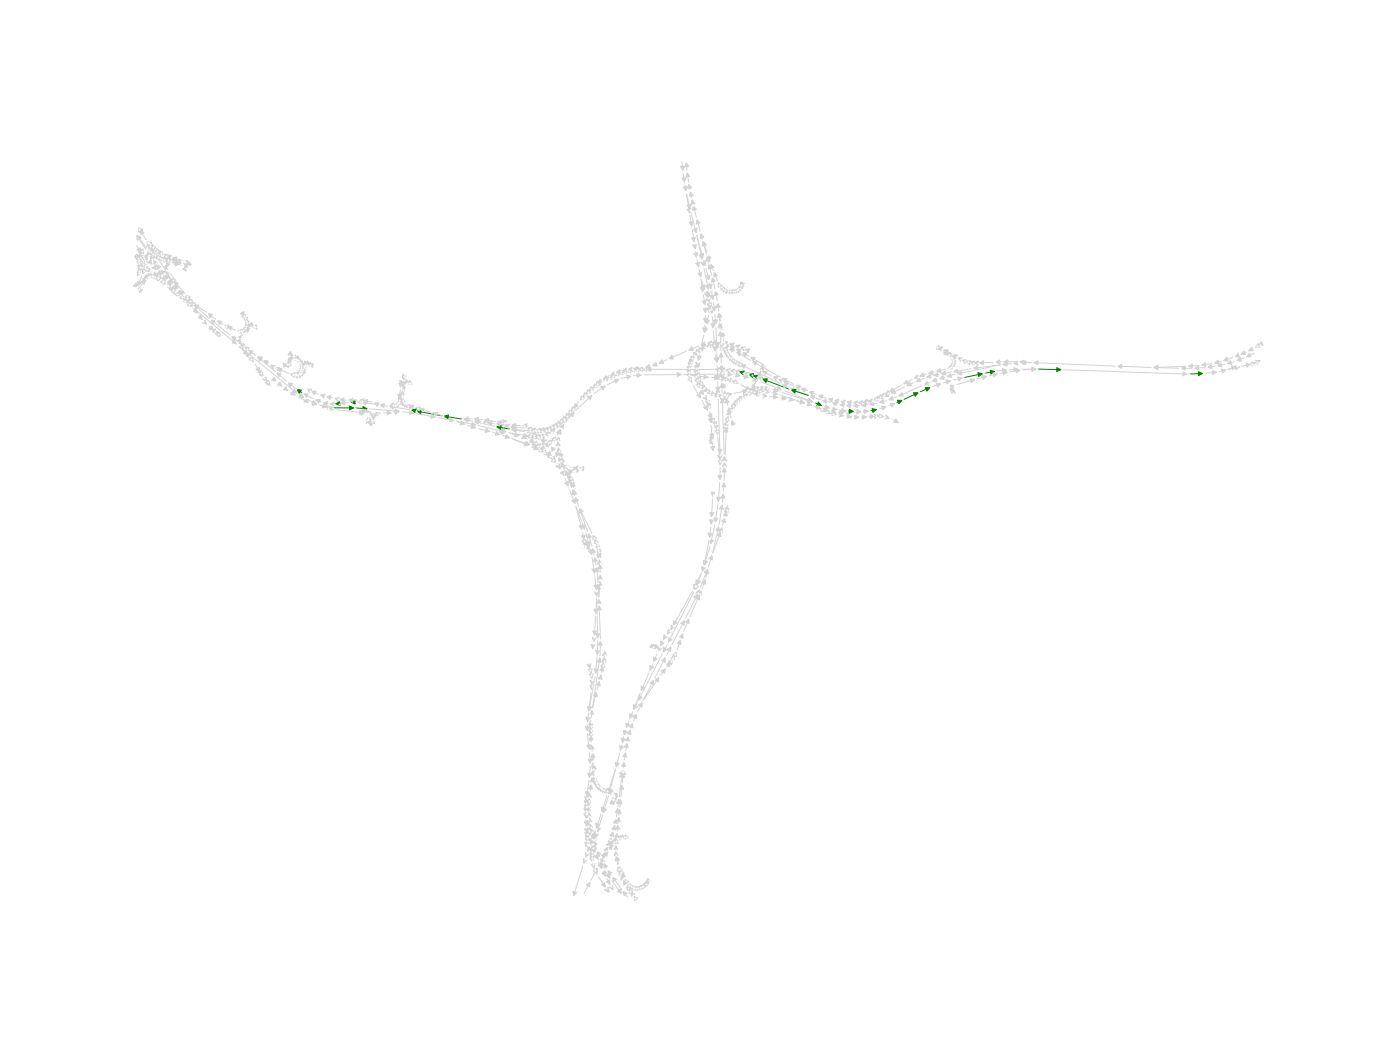

In [125]:
plt.figure(figsize=[3 * 6.4, 3 * 4.8])

edge_colors = ["green" if (u, v) in opt_sensors or (v, u) in opt_sensors else "lightgray" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

In [126]:
mse(flow_prediction_nls(G, {s: labeled_flows[s] for s in opt_sensors}), labeled_flows)

array([13813333.77654539])

In [127]:
preds = flow_prediction_nls(G, {s: labeled_flows[s] for s in opt_sensors})

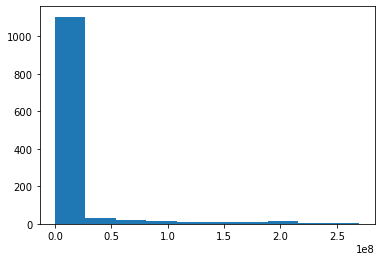

In [131]:
plt.hist([v[0] for v in errs.values()])
plt.show()

In [175]:
labeled_speeds = get_labels_from_df(edgelist, 2, 3, -1)
opt_sensors = choose_sensors(G, labeled_speeds, speed_prediction, mse, lazy=True)

KeyError: (1614922744, 1614922747)

## Benchmarks

In [167]:
"""
Randomly select k edges from the graph.
"""
def choose_sensors_random(G, k=None):
    if k == None:
        k = int(G.number_of_edges() / 50)
        
    choice = np.random.choice(G.number_of_edges(), k)
    selected = []
    for i, e in enumerate(G.edges):
        if i in choice:
            selected.append(e)
        
    return selected

In [168]:
choose_sensors_random(J, 2)

[(0, 8), (1, 5)]

In [171]:
random_sensors = choose_sensors_random(G)
preds = flow_prediction_nls(G, {s: labeled_flows[s] for s in random_sensors})
mse(labeled_flows, preds)

array([16167713.52777613])

### TODO

Get benchmarks from active learning paper

## Error Metrics

In [152]:
def geh(pred, actual):
    if pred == actual == 0:
        return np.array([0])
    return np.sqrt((2 * (pred - actual) ** 2) / (pred + actual))

In [134]:
def mape(pred_labels, labeled_edges):
    return 100 * sum([abs((v - pred_labels[k]) / v) for k, v in labeled_edges.items()]) / len(labeled_edges) 